In [7]:
from utils import (LastOnlyRegressorChain, plot_error_over_horizon, plot_most_influential_chained_prediction)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV

# 1. Data Loading

In [8]:
supply = pd.read_csv('data/Realised_Supply_Germany.csv', index_col=0, sep=';')
supply = supply[['Solar Power [MW]']]
supply.index = pd.to_datetime(supply.index, format='%d.%m.%y %H:%M')
supply['Solar Power [MW]'] = supply['Solar Power [MW]'].str.replace('.', '', regex=False)
supply['Solar Power [MW]'] = supply['Solar Power [MW]'].str.replace(',', '.', regex=False)
supply['Solar Power [MW]'] = pd.to_numeric(supply['Solar Power [MW]'], errors='raise')


In [9]:
weather = pd.read_csv('data/Weather_Data_Germany.csv', sep=',', decimal='.')
weather.time = pd.to_datetime(weather.time, format='%Y-%m-%d %H:%M:%S')
weather.set_index('time', inplace=True)
weather = weather.drop(columns=['forecast_origin'])

In [10]:
weather2022 = pd.read_csv('data/Weather_Data_Germany_2022.csv', sep=',', decimal='.')
weather2022.time = pd.to_datetime(weather2022.time, format='%Y-%m-%d %H:%M:%S')
weather2022.set_index('time', inplace=True)
weather2022 = weather2022.drop(columns=['forecast_origin'])

In [11]:
weather = pd.concat([weather,weather2022])
print(f"Start date: {weather.index.min()}")
print(f"End date: {weather.index.max()}")

Start date: 2019-01-01 00:00:00
End date: 2022-12-31 23:00:00


## 2 Data Preprocessing

## 2.1 Reduce time precision to match weather

In [12]:
# Match time precision by summing up to the hour
supply = supply.resample('H').sum()

## 2.2 Aggregate over weather stations
Since the Supply Data is Germany wide, we will average the weather from different locations as XGBoost needs tabular data.

In [13]:
# Aggregate weather data from different weather stations
weather = weather.drop(columns=['z', 'latitude', 'longitude'])
weather = weather.groupby(weather.index).mean()

## 2.3 Normalize values
XGBoost is sensitive to unnormalized values so we set the mean 0 and the std 1 using the scipy standard scaler

In [14]:
scaler = StandardScaler()
weather_scaled = scaler.fit_transform(weather)
weather_scaled = pd.DataFrame(weather_scaled, index=weather.index, columns=weather.columns)

## 2.4 Train/Test Split
Splitting in time series data should always be in order and contain a whole season, so we are using 2022 as the test set.

In [15]:
# Train-test split
cutoff_date = pd.to_datetime('2022-01-01')

X_train = weather_scaled[weather_scaled.index < cutoff_date]
X_test = weather_scaled[weather_scaled.index >= cutoff_date]
y_train = supply[supply.index < cutoff_date]
y_test = supply[supply.index >= cutoff_date]
# Write the data to CSV files
X_train.to_csv('tmp/X_train.csv', sep=';', decimal=',')
X_test.to_csv('tmp/X_test.csv', sep=';', decimal=',')
y_train.to_csv('tmp/y_train.csv', sep=';', decimal=',')
y_test.to_csv('tmp/y_test.csv', sep=';', decimal=',')

## 3 Feature Selection
There are still quite a lot of features in the weather data. We can use Lasso Regression to find the most important ones.

In [16]:
# Load Data
X_train = pd.read_csv('tmp/X_train.csv', sep=';', decimal=',', index_col=0)
X_test = pd.read_csv('tmp/X_test.csv', sep=';', decimal=',', index_col=0)
y_train = pd.read_csv('tmp/y_train.csv', sep=';', decimal=',', index_col=0)
y_test = pd.read_csv('tmp/y_test.csv', sep=';', decimal=',', index_col=0)

In [17]:
lasso_cv = LassoCV(cv= 5, random_state=1312).fit(X_train, y_train.squeeze())
best_alpha = lasso_cv.alpha_

lasso = Lasso(alpha=150, max_iter=1000, random_state=1312)
_ = lasso.fit(X_train, y_train.squeeze())

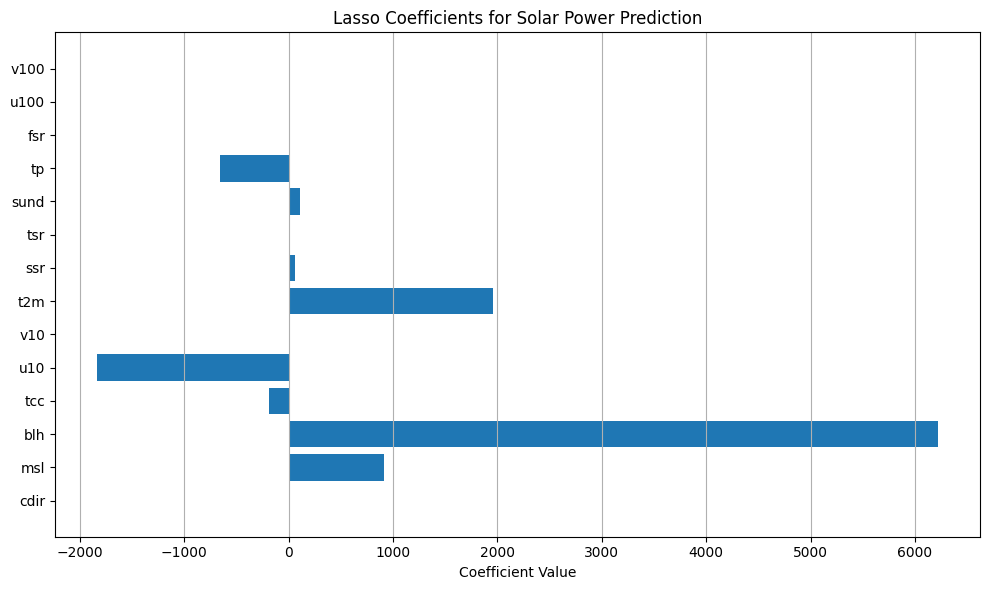

In [18]:
# Plot coefficients
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, lasso.coef_)
plt.xlabel('Coefficient Value')
plt.title('Lasso Coefficients for Solar Power Prediction')
plt.grid(axis='x')
plt.tight_layout()

In [19]:
# Drop Features with zero coefficients
X_train_selected = X_train.loc[:, lasso.coef_ != 0]
X_test_selected = X_test.loc[:, lasso.coef_ != 0]
print(f"Number of features after Lasso: {X_train_selected.shape[1]}")

Number of features after Lasso: 8


In [20]:
# Save the selected features
X_train_selected.to_csv('tmp/X_train_selected.csv', sep=';', decimal=',')
X_test_selected.to_csv('tmp/X_test_selected.csv', sep=';', decimal=',')